In [1]:
from __future__ import unicode_literals
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from helper_funcs import * 
from torchvision.models import *
from torchvision.models.resnet import BasicBlock

import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models

from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.optim as optim

from numpy import linalg as LA

import tensorboardX

batch_size=128
random_state = 42 
learning_rate = 1e-3


# https://www.kaggle.com/tonysun94/pytorch-1-0-1-on-mnist-acc-99-8

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

tb_writer = tensorboardX.SummaryWriter('storage/resnet-sl-v2')


cuda:0


In [3]:
df = pd.read_csv("data/label-mappings.csv")

In [4]:
def get_accuracy(testloader, net, batch=False):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels, _ = data
            outputs = net(images.to(device))
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels.to(device)).sum().item()
            
            gt = 0 
            vt = 0 
            ct = 0 
            
            if batch: 
                overall = 100 * correct / total
                
                for (pred, label) in zip(predicted, labels):                    
                    l = label.item()
                    p = pred.item()
                    g, v, c = df[df.label == l].grapheme_root.values[0], \
                        df[df.label == l].vowel_diacritic.values[0], \
                        df[df.label == l].consonant_diacritic.values[0]
                    
                    pg, pv, pc = df[df.label == p].grapheme_root.values[0], \
                        df[df.label == p].vowel_diacritic.values[0], \
                        df[df.label == p].consonant_diacritic.values[0]   
                    
                    if g == pg: 
                        gt += 1 
                    if v == pv: 
                        vt += 1
                    if c == pc: 
                        ct+=1 
                g_acc = 100*gt/batch_size
                v_acc = 100*vt/batch_size
                c_acc = 100*ct/batch_size
                overall = (g_acc*2 + v_acc + c_acc) /4 
                
                return g_acc, v_acc, c_acc, overall
                
    overall = 100 * correct / total
    
    return overall

In [5]:
def show_errors(testloader, net, n=10):
    count = 0
    ims = []
    preds = []
    actual = []
    with torch.no_grad():
        for data in testloader:
            images, labels, _ = data
            outputs = net(images.to(device))
            _, predicted = torch.max(outputs.data, 1)            
            
            for (im, pred, label) in zip(images, predicted, labels):
                if pred.numpy() != label.numpy():
                    count += 1
                    ims.append(im.numpy())
                    preds.append(pred)
                    actual.append(label)
                    
                if count >= n: 
                    return ims, preds, actual 
                
    plot_gallery2(ims, preds, 2, 5)

In [6]:
transform=transforms.Compose([
    transforms.Resize(28),
    transforms.ToTensor(),
])

trainset = BengaliDataset("data/train.csv","data/trainsplit", transform)
testset = BengaliDataset("data/test.csv","data/testsplit", transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                         shuffle=True, num_workers=0)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=True, num_workers=0)

df = pd.read_csv("data/train.csv")
classes = list(range(df.label.max()+1))
n_classes = len(classes)

In [7]:
images, labels,t = next(iter(trainloader))
# images, labels,t = next(iter(testloader))

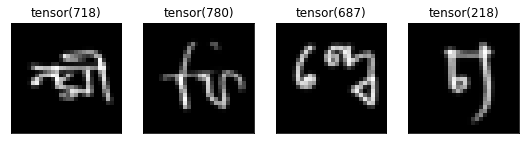

In [8]:
# show images
plot_gallery2(images,labels,1,4)

In [9]:
df.label.max()+1

1292

In [10]:
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models.resnet import ResNet, BasicBlock, Bottleneck


class MNISTResNet(ResNet):
    def __init__(self):
        super(MNISTResNet, self).__init__(BasicBlock, [2, 2, 2, 2], num_classes=n_classes) # Based on ResNet18
        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=1, padding=3,bias=False)

model = MNISTResNet()
# print(model)

In [11]:
def train(train_loader, model, criterion, optimizer, epoch):
    model.train()

    for batch_idx, (data, target, _) in enumerate(train_loader):
        # if GPU available, move data and target to GPU
        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()
        
        # compute output and loss
        output = model(data)
        loss = criterion(output, target)
        
        # TODO:
        # 1. add batch metric (acc1, acc5)
        # 2. add average metric top1=sum(acc1)/batch_idx, top5 = sum(acc5)/batch_idx
        
        # backward and update model
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (batch_idx + 1)% 100 == 0:
            step = (epoch*100) + batch_idx 
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, (batch_idx + 1) * len(data), len(train_loader.dataset),
                100. * (batch_idx + 1) / len(train_loader), loss.data.item()))
            
    acc_g, acc_v, acc_c, overall = get_accuracy(testloader, model, batch=True)
    tb_writer.add_scalar("loss", loss, step)

    tb_writer.add_scalar("grapheme-root-accuracy", acc_g, step)
    tb_writer.add_scalar("vowel-diatric-accuracy", acc_v, step)
    tb_writer.add_scalar("consonant_diatric-accuracy", acc_c, step)
    tb_writer.add_scalar("accuracy", overall, step)


    print('[%d, %5d] loss: %.3f \t test accuracy: %.3f' % (epoch + 1, step, loss, overall))

            

In [12]:
def validate(val_loader, model, criterion):
    model.eval()
    loss = 0
    correct = 0
    
    for _, (data, target, _) in enumerate(val_loader):
        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()
        
        output = model(data)
        
        loss += criterion(output, target).data.item()

        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()
        
    loss /= len(val_loader.dataset)
        
    print('\nOn Val set Average loss: {:.4f}, Accuracy: {}/{} ({:.3f}%)\n'.format(
        loss, correct, len(val_loader.dataset),
        100.0 * float(correct) / len(val_loader.dataset)))

In [13]:
# example config, use the comments to get higher accuracy
total_epoches = 20 # 50
step_size = 5     # 10
base_lr = 0.01    # 0.01

optimizer = optim.Adam(model.parameters(), lr=base_lr)
criterion = nn.CrossEntropyLoss()
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=0.1)

if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()

In [ ]:
track_loss = []
track_accuracy = []
for epoch in range(total_epoches):
    train(train_loader=trainloader, model=model, criterion=criterion, optimizer=optimizer, epoch=epoch)
    validate(val_loader=testloader, model=model, criterion=criterion)
    exp_lr_scheduler.step()

Train Epoch: 0 [12800/134562 (10%)]	Loss: 7.171162
Train Epoch: 0 [25600/134562 (19%)]	Loss: 7.123380


In [ ]:
torch.save(model.state_dict(), "resnet.pth")

In [ ]:
sample,labels,_ = next(iter(testloader))
output = model(sample.to(device))
pred = output.data.max(1, keepdim=True)[1].cpu()


In [ ]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt 
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay
)

from pylab import rcParams
rcParams['figure.figsize'] = 13, 13

# plt.figure(figsize=(12,12))
cn_matrix = confusion_matrix(
    y_true=labels.numpy(),
    y_pred=pred,
    labels=list(range(1293)),
    normalize="true",
)
ConfusionMatrixDisplay(cn_matrix, list(range(1293))).plot(
    include_values=False, xticks_rotation="vertical"
)
plt.title("Colors")

plt.tight_layout()
plt.show()
